In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import scoring_utils

In [2]:
df = pd.read_csv('../data/data_clean.csv')

for col in df.columns:
    print(col)

City
State
Bank
ApprovalFY
Term
NoEmp
CreateJob
RetainedJob
FranchiseCode
UrbanRural
RevLineCr
LowDoc
GrAppv
SBA_Appv
Default
NAICS_i
isNewBusiness
isFranchise
SBARatio
InterestRate


In [3]:
# one-hot encode UrbanRural and include it
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

UR_encoded = OHE.fit_transform(df[['UrbanRural']])
UR_enc_df = pd.DataFrame(UR_encoded,columns = OHE.get_feature_names_out(['UrbanRural']))
df = pd.concat([df,UR_enc_df], axis=1)
df.drop(columns=['UrbanRural'], inplace=True)


In [4]:
# Look for and remove outliers

def remove_outliers(df:pd.DataFrame, c:str):
    z_scores = np.abs((df[c] - df[c].mean())/df[c].std())
    no_outliers = df[z_scores < 3]
    return no_outliers

#remove outliers from features

have_outliers = ['Term','NoEmp','CreateJob','RetainedJob','GrAppv','SBA_Appv']

for col in have_outliers:
    print(f"\n\nCol: {col}")
    print("\nBefore:")
    for s in df[col].describe().to_string().split('\n'):
        print(f'\t{s}')
    df = remove_outliers(df,col)
    print("\nAfter:")
    for s in df[col].describe().to_string().split('\n'):
        print(f'\t{s}')




Col: Term

Before:
	count    870514.000000
	mean        111.508946
	std          79.177488
	min           0.000000
	25%          60.000000
	50%          84.000000
	75%         120.000000
	max         569.000000

After:
	count    870352.000000
	mean        111.458809
	std          79.097905
	min           0.000000
	25%          60.000000
	50%          84.000000
	75%         120.000000
	max         349.000000


Col: NoEmp

Before:
	count    870352.000000
	mean         11.478524
	std          74.594736
	min           0.000000
	25%           2.000000
	50%           4.000000
	75%          10.000000
	max        9999.000000

After:
	count    868960.000000
	mean         10.020323
	std          17.337608
	min           0.000000
	25%           2.000000
	50%           4.000000
	75%          10.000000
	max         235.000000


Col: CreateJob

Before:
	count    868960.000000
	mean          8.526285
	std         239.181681
	min           0.000000
	25%           0.000000
	50%           0.000000
	75

In [5]:
# Select Features (X) and Target (Y)
#X = df[['ApprovalFY','Term','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','RevLineCr','LowDoc','GrAppv','SBA_Appv','NAICS_i','isNewBusiness','isFranchise','SBARatio','InterestRate']]
experimental_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']
target = 'Default'
features = [f for f in df.columns if f not in experimental_features and f not in target]

X = df[features]
Y = df[target]

In [6]:
# Do a train-test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X,Y,test_size=0.4,random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=.5)



In [7]:
# Scale Features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_cv_scaled = sc.transform(X_cv)
X_test_scaled = sc.transform(X_test)
X_scaled =sc.transform(X)

In [8]:
model = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5, C=0.4, verbose=2, n_jobs=-1, class_weight='balanced')
model.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.01258549
Epoch 3, change: 0.00871258
Epoch 4, change: 0.00480832
Epoch 5, change: 0.00457788
Epoch 6, change: 0.00470580
Epoch 7, change: 0.00282500
Epoch 8, change: 0.00227735
Epoch 9, change: 0.00187284
Epoch 10, change: 0.00165353
Epoch 11, change: 0.00138174
Epoch 12, change: 0.00123484
Epoch 13, change: 0.00106060
Epoch 14, change: 0.00092274
Epoch 15, change: 0.00080440
Epoch 16, change: 0.00069950
Epoch 17, change: 0.00060982
Epoch 18, change: 0.00052790
Epoch 19, change: 0.00046171
Epoch 20, change: 0.00039798
Epoch 21, change: 0.00034493
Epoch 22, change: 0.00030146
Epoch 23, change: 0.00026261
Epoch 24, change: 0.00022623
Epoch 25, change: 0.00019744
Epoch 26, change: 0.00017201
Epoch 27, change: 0.00014970
Epoch 28, change: 0.00012962
Epoch 29, change: 0.00011316
convergence after 30 epochs took 7 seconds


LogisticRegression(C=0.4, class_weight='balanced', l1_ratio=0.5, n_jobs=-1,
                   penalty='elasticnet', solver='saga', verbose=2)

In [9]:
coefficients = model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print(coef_df)

          Feature  Coefficient
0            Term    -1.943214
1           NoEmp    -0.286349
2       CreateJob     0.004514
3     RetainedJob    -0.001227
4       RevLineCr    -0.085244
5          LowDoc    -0.342056
6          GrAppv     0.096919
7        SBA_Appv     0.222138
8   isNewBusiness    -0.008082
9     isFranchise     0.015676
10       SBARatio     0.297701
11   InterestRate     0.502147
12   UrbanRural_0    -0.475069
13   UrbanRural_1     0.349272
14   UrbanRural_2     0.156609


In [10]:
#make predictions
yhat_train = model.predict(X_train_scaled)
yhat_cv = model.predict(X_test_scaled)

score = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train, "Logit Train"),
    scoring_utils.get_metrics(y_test, yhat_cv, "Logit CV")
])

score

,Recall,Precision,ROC,F1
Logit Train,0.823855,0.383772,0.769638,0.523626
Logit CV,0.822180,0.384069,0.768746,0.523564


In [11]:
model.get_params()

{'C': 0.4,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.5,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 2,
 'warm_start': False}

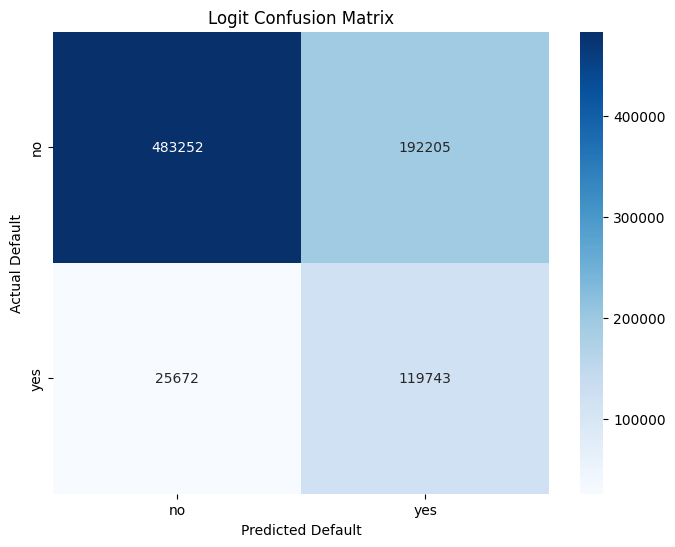

In [12]:
yhat_total = model.predict(X_scaled)
scoring_utils.get_confusion_matrix(Y, yhat_total, "Logit")

In [13]:
scoring_utils.get_profit(X, Y, yhat_total)

3464067646.65

This fucker overfits to the max. You need to regularize it as crazy. You can keep all the columns if you want to but it's not necessary. First, do something similar to the code in importance_analysis (the graphs that draw a line for CV and a line for testing) and iterate over different types of regularization.
If I was you I would pick elasticnet with a saga solver and iterate over different values of l1. The docs explain pretty good. Then change the solver and try with other penalties.